In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
import torchvision.models as models
from tqdm import tqdm
import seaborn as sns

## Contents:
* [CNN model definition](#first-bullet)
* [Test func definition](#second-bullet)
* [ResNet CLR tests](#third-bullet)
* [ResNet Fixed tests](#fourth-bullet)
* [CNN CLR tests](#fifth-bullet)
* [CNN Fixed tests](#sixth-bullet)
* [Experiment Analysis](#seventh-bullet)

## CNN model definition <a class="anchor" id="first-bullet"></a>

In [163]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

## Test func definition <a class="anchor" id="second-bullet"></a>

In [17]:
def test(model, device, valid_loader):
    model.eval()
    test_losses = []
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)
            test_losses.append(test_loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader)
    

    
    return np.mean(test_losses), correct / len(valid_loader.dataset)

In [21]:
logs = []
new_logs = dict()
new_logs['clr']=dict()
new_logs['reg']=dict()
for i in range(10):
    new_logs['clr'][i]=[]
    new_logs['reg'][i]=[]

## ResNet CLR instances <a class="anchor" id="third-bullet"></a>

In [22]:

clr_val_accs = []
clr_train_accs = []
for _ in range (10):
    model =models.resnet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,0.005,0.02, 4*len(train_loader))
    for epoch in range(10):
        losses =[]
        accuracies=[]
        with tqdm(train_loader, unit="batch") as tepoch:
                for i, (images, labels) in enumerate(train_loader):

                # Send data to GPU
                    images, labels = images.to(device), labels.to(device)

                    # Clear the gradients
                    optimizer.zero_grad()

                    # Forward propagation 
                    outputs = model(images)  
                    # Calculating loss with softmax to obtain cross entropy loss
                    loss = criterion(outputs, labels)

                    # Backward propation
                    loss.backward()
                    clip_grad_norm_(model.parameters(), 5)
                    # Update the LR
                    optimizer.step()
                    scheduler.step()

                    losses.append(loss.item())
                    lr_sched_test = scheduler.get_lr()

                    # Updating gradients




                    # Total number of labels
                    total = labels.size(0)

                    # Obtaining predictions from max value
                    _, predicted = torch.max(outputs.data, 1)

                    # Calculate the number of correct answers
                    correct = (predicted == labels).sum().item()

                    accuracies.append(correct/total)
#                     print(i)
    #             print("completed iteration ",i)
        print("-- Epoch {}, average training loss: {:.4f}, average training accuracy: {:2f}".format(epoch, np.mean(losses), np.mean(accuracies)))

        valid_loss, valid_acc = test(model, device, test_loader)
        print("-- Epoch {}, average test loss: {:.4f}, average test accuracy: {:2f}".format(epoch, np.mean(valid_loss), np.mean(valid_acc)))
        logs.append({
                'acc':np.mean(accuracies),
                "loss":np.mean(losses),
                "val_acc":valid_acc,
                "val_loss":valid_loss
        })
        new_logs['clr'][epoch].append(valid_acc)
    clr_val_accs.append(logs[-1]['val_acc'])
    clr_train_accs.append(logs[-1]['acc'])

  0%|                                                                                       | 0/782 [01:14<?, ?batch/s]


-- Epoch 0, average training loss: 1.8777, average training accuracy: 0.361193


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.7909, average test accuracy: 0.389800


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 1, average training loss: 1.5786, average training accuracy: 0.431726


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4509, average test accuracy: 0.496600


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 2, average training loss: 1.4226, average training accuracy: 0.488631


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.4263, average test accuracy: 0.496600


  0%|                                                                                       | 0/782 [01:25<?, ?batch/s]


-- Epoch 3, average training loss: 1.3070, average training accuracy: 0.534067


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.1869, average test accuracy: 0.568700


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 4, average training loss: 1.2003, average training accuracy: 0.573010


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0822, average test accuracy: 0.616300


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 5, average training loss: 1.1021, average training accuracy: 0.611093


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0207, average test accuracy: 0.645800


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 6, average training loss: 1.0159, average training accuracy: 0.641065


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9956, average test accuracy: 0.656900


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 7, average training loss: 0.9360, average training accuracy: 0.669777


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8691, average test accuracy: 0.696900


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 8, average training loss: 0.8877, average training accuracy: 0.686941


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.9754, average test accuracy: 0.668800


  0%|                                                                                       | 0/782 [01:22<?, ?batch/s]


-- Epoch 9, average training loss: 0.9015, average training accuracy: 0.683164
-- Epoch 9, average test loss: 0.9368, average test accuracy: 0.680300


  0%|                                                                                       | 0/782 [01:24<?, ?batch/s]


-- Epoch 0, average training loss: 1.8572, average training accuracy: 0.359495


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.4879, average test accuracy: 0.455000


  0%|                                                                                       | 0/782 [01:23<?, ?batch/s]


-- Epoch 1, average training loss: 1.5719, average training accuracy: 0.434023


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.6023, average test accuracy: 0.461100


  0%|                                                                                       | 0/782 [01:24<?, ?batch/s]


-- Epoch 2, average training loss: 1.4092, average training accuracy: 0.492767


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3259, average test accuracy: 0.514100


  0%|                                                                                       | 0/782 [01:25<?, ?batch/s]


-- Epoch 3, average training loss: 1.2980, average training accuracy: 0.534667


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.1457, average test accuracy: 0.596800


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 4, average training loss: 1.1944, average training accuracy: 0.575348


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0802, average test accuracy: 0.619000


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 5, average training loss: 1.0946, average training accuracy: 0.612012


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0674, average test accuracy: 0.630900


  0%|                                                                                       | 0/782 [01:25<?, ?batch/s]


-- Epoch 6, average training loss: 1.0104, average training accuracy: 0.643482


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9663, average test accuracy: 0.668100


  0%|                                                                                       | 0/782 [01:29<?, ?batch/s]


-- Epoch 7, average training loss: 0.9297, average training accuracy: 0.672215


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.9734, average test accuracy: 0.663500


  0%|                                                                                       | 0/782 [01:31<?, ?batch/s]


-- Epoch 8, average training loss: 0.8879, average training accuracy: 0.686641


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8555, average test accuracy: 0.707300


  0%|                                                                                       | 0/782 [01:27<?, ?batch/s]


-- Epoch 9, average training loss: 0.8983, average training accuracy: 0.682065
-- Epoch 9, average test loss: 0.9736, average test accuracy: 0.668100


  0%|                                                                                       | 0/782 [01:33<?, ?batch/s]


-- Epoch 0, average training loss: 1.8664, average training accuracy: 0.355199


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.8456, average test accuracy: 0.359300


  0%|                                                                                       | 0/782 [01:32<?, ?batch/s]


-- Epoch 1, average training loss: 1.5655, average training accuracy: 0.434203


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4449, average test accuracy: 0.462900


  0%|                                                                                       | 0/782 [01:37<?, ?batch/s]


-- Epoch 2, average training loss: 1.4080, average training accuracy: 0.493047


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3565, average test accuracy: 0.520900


  0%|                                                                                       | 0/782 [01:45<?, ?batch/s]


-- Epoch 3, average training loss: 1.2941, average training accuracy: 0.537224


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.1743, average test accuracy: 0.579400


  0%|                                                                                       | 0/782 [01:36<?, ?batch/s]


-- Epoch 4, average training loss: 1.1861, average training accuracy: 0.576407


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.1196, average test accuracy: 0.609300


  0%|                                                                                       | 0/782 [01:35<?, ?batch/s]


-- Epoch 5, average training loss: 1.0925, average training accuracy: 0.614870


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0432, average test accuracy: 0.632700


  0%|                                                                                       | 0/782 [01:36<?, ?batch/s]


-- Epoch 6, average training loss: 1.0054, average training accuracy: 0.646639


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 1.0113, average test accuracy: 0.648300


  0%|                                                                                       | 0/782 [01:36<?, ?batch/s]


-- Epoch 7, average training loss: 0.9294, average training accuracy: 0.673933


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.9062, average test accuracy: 0.685300


  0%|                                                                                       | 0/782 [01:36<?, ?batch/s]


-- Epoch 8, average training loss: 0.8825, average training accuracy: 0.690157


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.9152, average test accuracy: 0.684200


  0%|                                                                                       | 0/782 [01:37<?, ?batch/s]


-- Epoch 9, average training loss: 0.8953, average training accuracy: 0.684003
-- Epoch 9, average test loss: 0.9341, average test accuracy: 0.680200


  0%|                                                                                       | 0/782 [01:41<?, ?batch/s]


-- Epoch 0, average training loss: 1.8566, average training accuracy: 0.363231


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.6951, average test accuracy: 0.407400


  0%|                                                                                       | 0/782 [01:38<?, ?batch/s]


-- Epoch 1, average training loss: 1.5813, average training accuracy: 0.427390


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4990, average test accuracy: 0.440800


  0%|                                                                                       | 0/782 [01:37<?, ?batch/s]


-- Epoch 2, average training loss: 1.4146, average training accuracy: 0.489710


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.2215, average test accuracy: 0.570500


  0%|                                                                                       | 0/782 [01:38<?, ?batch/s]


-- Epoch 3, average training loss: 1.2956, average training accuracy: 0.537444


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.2310, average test accuracy: 0.575300


  0%|                                                                                       | 0/782 [01:37<?, ?batch/s]


-- Epoch 4, average training loss: 1.1908, average training accuracy: 0.576886


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.1123, average test accuracy: 0.607200


  0%|                                                                                       | 0/782 [01:36<?, ?batch/s]


-- Epoch 5, average training loss: 1.1072, average training accuracy: 0.608156


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0343, average test accuracy: 0.637600


  0%|                                                                                       | 0/782 [01:33<?, ?batch/s]


-- Epoch 6, average training loss: 1.0243, average training accuracy: 0.636509


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9574, average test accuracy: 0.658700


  0%|                                                                                       | 0/782 [01:21<?, ?batch/s]


-- Epoch 7, average training loss: 0.9390, average training accuracy: 0.668099


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8738, average test accuracy: 0.694900


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 8, average training loss: 0.9038, average training accuracy: 0.680806


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.9585, average test accuracy: 0.665900


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 9, average training loss: 0.9082, average training accuracy: 0.679548


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 9, average test loss: 0.9078, average test accuracy: 0.677900


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 0, average training loss: 1.8673, average training accuracy: 0.356897


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.5829, average test accuracy: 0.449900


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 1, average training loss: 1.5843, average training accuracy: 0.427170


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4441, average test accuracy: 0.475600


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 2, average training loss: 1.4281, average training accuracy: 0.486953


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3368, average test accuracy: 0.525100


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 3, average training loss: 1.3121, average training accuracy: 0.531070


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.2121, average test accuracy: 0.580200


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 4, average training loss: 1.2103, average training accuracy: 0.567156


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0952, average test accuracy: 0.610000


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 5, average training loss: 1.1135, average training accuracy: 0.604160


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0636, average test accuracy: 0.629500


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 6, average training loss: 1.0275, average training accuracy: 0.634950


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9109, average test accuracy: 0.680100


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 7, average training loss: 0.9471, average training accuracy: 0.663103


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.9316, average test accuracy: 0.676100


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 8, average training loss: 0.9100, average training accuracy: 0.677490


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8753, average test accuracy: 0.689100


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 9, average training loss: 0.9136, average training accuracy: 0.678549


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 9, average test loss: 0.8952, average test accuracy: 0.689900


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 0, average training loss: 1.8638, average training accuracy: 0.358556


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 2.9169, average test accuracy: 0.288400


  0%|                                                                                       | 0/782 [01:27<?, ?batch/s]


-- Epoch 1, average training loss: 1.5755, average training accuracy: 0.429548


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.5091, average test accuracy: 0.452800


  0%|                                                                                       | 0/782 [01:43<?, ?batch/s]


-- Epoch 2, average training loss: 1.4187, average training accuracy: 0.488571


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.4128, average test accuracy: 0.485500


  0%|                                                                                       | 0/782 [02:00<?, ?batch/s]


-- Epoch 3, average training loss: 1.3028, average training accuracy: 0.538223


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.2151, average test accuracy: 0.564600


  0%|                                                                                       | 0/782 [02:20<?, ?batch/s]


-- Epoch 4, average training loss: 1.2006, average training accuracy: 0.571971


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0561, average test accuracy: 0.626200


  0%|                                                                                       | 0/782 [02:16<?, ?batch/s]


-- Epoch 5, average training loss: 1.1078, average training accuracy: 0.607037


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 0.9946, average test accuracy: 0.644800


  0%|                                                                                       | 0/782 [02:20<?, ?batch/s]


-- Epoch 6, average training loss: 1.0184, average training accuracy: 0.640325


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9651, average test accuracy: 0.668000


  0%|                                                                                       | 0/782 [02:19<?, ?batch/s]


-- Epoch 7, average training loss: 0.9376, average training accuracy: 0.668418


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8950, average test accuracy: 0.685600


  0%|                                                                                       | 0/782 [02:19<?, ?batch/s]


-- Epoch 8, average training loss: 0.9003, average training accuracy: 0.683104


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8933, average test accuracy: 0.687500


  0%|                                                                                       | 0/782 [02:19<?, ?batch/s]


-- Epoch 9, average training loss: 0.9020, average training accuracy: 0.681466
-- Epoch 9, average test loss: 0.8835, average test accuracy: 0.692700


  0%|                                                                                       | 0/782 [02:30<?, ?batch/s]


-- Epoch 0, average training loss: 1.8443, average training accuracy: 0.363931


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.6695, average test accuracy: 0.408800


  0%|                                                                                       | 0/782 [02:30<?, ?batch/s]


-- Epoch 1, average training loss: 1.5730, average training accuracy: 0.433584


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.3527, average test accuracy: 0.504700


  0%|                                                                                       | 0/782 [02:29<?, ?batch/s]


-- Epoch 2, average training loss: 1.4167, average training accuracy: 0.490789


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3521, average test accuracy: 0.527300


  0%|                                                                                       | 0/782 [02:24<?, ?batch/s]


-- Epoch 3, average training loss: 1.3018, average training accuracy: 0.537644


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.1852, average test accuracy: 0.581600


  0%|                                                                                       | 0/782 [02:11<?, ?batch/s]


-- Epoch 4, average training loss: 1.2009, average training accuracy: 0.574708


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.1039, average test accuracy: 0.611200


  0%|                                                                                       | 0/782 [02:26<?, ?batch/s]


-- Epoch 5, average training loss: 1.1009, average training accuracy: 0.612092


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0525, average test accuracy: 0.632000


  0%|                                                                                       | 0/782 [02:24<?, ?batch/s]


-- Epoch 6, average training loss: 1.0208, average training accuracy: 0.638187


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9168, average test accuracy: 0.681400


  0%|                                                                                       | 0/782 [02:24<?, ?batch/s]


-- Epoch 7, average training loss: 0.9315, average training accuracy: 0.674393


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8546, average test accuracy: 0.702100


  0%|                                                                                       | 0/782 [02:23<?, ?batch/s]


-- Epoch 8, average training loss: 0.8959, average training accuracy: 0.684483


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 1.0946, average test accuracy: 0.631600


  0%|                                                                                       | 0/782 [02:23<?, ?batch/s]


-- Epoch 9, average training loss: 0.9026, average training accuracy: 0.684123
-- Epoch 9, average test loss: 0.8770, average test accuracy: 0.695300


  0%|                                                                                       | 0/782 [02:35<?, ?batch/s]


-- Epoch 0, average training loss: 1.8610, average training accuracy: 0.360374


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 2.1734, average test accuracy: 0.350600


  0%|                                                                                       | 0/782 [02:32<?, ?batch/s]


-- Epoch 1, average training loss: 1.5774, average training accuracy: 0.430087


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4794, average test accuracy: 0.477100


  0%|                                                                                       | 0/782 [02:29<?, ?batch/s]


-- Epoch 2, average training loss: 1.4135, average training accuracy: 0.493566


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3955, average test accuracy: 0.505800


  0%|                                                                                       | 0/782 [01:56<?, ?batch/s]


-- Epoch 3, average training loss: 1.3041, average training accuracy: 0.534247


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.3120, average test accuracy: 0.541400


  0%|                                                                                       | 0/782 [01:21<?, ?batch/s]


-- Epoch 4, average training loss: 1.1977, average training accuracy: 0.575048


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.1917, average test accuracy: 0.582800


  0%|                                                                                       | 0/782 [01:25<?, ?batch/s]


-- Epoch 5, average training loss: 1.0975, average training accuracy: 0.611613


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.0602, average test accuracy: 0.625500


  0%|                                                                                       | 0/782 [01:26<?, ?batch/s]


-- Epoch 6, average training loss: 1.0102, average training accuracy: 0.640885


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 1.0001, average test accuracy: 0.655000


  0%|                                                                                       | 0/782 [01:22<?, ?batch/s]


-- Epoch 7, average training loss: 0.9368, average training accuracy: 0.667959


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8652, average test accuracy: 0.698800


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 8, average training loss: 0.8967, average training accuracy: 0.685902


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8697, average test accuracy: 0.694500


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 9, average training loss: 0.9039, average training accuracy: 0.682864
-- Epoch 9, average test loss: 0.9745, average test accuracy: 0.671600


  0%|                                                                                       | 0/782 [01:21<?, ?batch/s]


-- Epoch 0, average training loss: 1.8475, average training accuracy: 0.364630


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 2.2455, average test accuracy: 0.317800


  0%|                                                                                       | 0/782 [01:25<?, ?batch/s]


-- Epoch 1, average training loss: 1.5701, average training accuracy: 0.432864


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.5372, average test accuracy: 0.462600


  0%|                                                                                       | 0/782 [01:22<?, ?batch/s]


-- Epoch 2, average training loss: 1.3887, average training accuracy: 0.505395


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.2307, average test accuracy: 0.565700


  0%|                                                                                       | 0/782 [01:19<?, ?batch/s]


-- Epoch 3, average training loss: 1.2703, average training accuracy: 0.550392


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.1134, average test accuracy: 0.606100


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 4, average training loss: 1.1602, average training accuracy: 0.592032


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0464, average test accuracy: 0.628200


  0%|                                                                                       | 0/782 [01:15<?, ?batch/s]


-- Epoch 5, average training loss: 1.0748, average training accuracy: 0.621923


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 0.9779, average test accuracy: 0.662400


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 6, average training loss: 0.9919, average training accuracy: 0.648857


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.8945, average test accuracy: 0.686400


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 7, average training loss: 0.9151, average training accuracy: 0.678149


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.8517, average test accuracy: 0.704500


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 8, average training loss: 0.8695, average training accuracy: 0.693814


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8610, average test accuracy: 0.700400


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 9, average training loss: 0.8833, average training accuracy: 0.690677
-- Epoch 9, average test loss: 0.8842, average test accuracy: 0.699400


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 0, average training loss: 1.8597, average training accuracy: 0.360654


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 0, average test loss: 1.5879, average test accuracy: 0.446300


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 1, average training loss: 1.5843, average training accuracy: 0.427430


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 1, average test loss: 1.4740, average test accuracy: 0.462100


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 2, average training loss: 1.4231, average training accuracy: 0.487232


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 2, average test loss: 1.3196, average test accuracy: 0.532500


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 3, average training loss: 1.3100, average training accuracy: 0.532149


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 3, average test loss: 1.2674, average test accuracy: 0.548000


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 4, average training loss: 1.2006, average training accuracy: 0.570652


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 4, average test loss: 1.0802, average test accuracy: 0.621800


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 5, average training loss: 1.0991, average training accuracy: 0.611653


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 5, average test loss: 1.1601, average test accuracy: 0.602300


  0%|                                                                                       | 0/782 [01:16<?, ?batch/s]


-- Epoch 6, average training loss: 1.0174, average training accuracy: 0.640145


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 6, average test loss: 0.9321, average test accuracy: 0.670000


  0%|                                                                                       | 0/782 [01:17<?, ?batch/s]


-- Epoch 7, average training loss: 0.9339, average training accuracy: 0.670976


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 7, average test loss: 0.9223, average test accuracy: 0.675300


  0%|                                                                                       | 0/782 [01:18<?, ?batch/s]


-- Epoch 8, average training loss: 0.8946, average training accuracy: 0.685102


  0%|                                                                                       | 0/782 [00:00<?, ?batch/s]

-- Epoch 8, average test loss: 0.8986, average test accuracy: 0.682900


  0%|                                                                                       | 0/782 [01:20<?, ?batch/s]


-- Epoch 9, average training loss: 0.9022, average training accuracy: 0.682285
-- Epoch 9, average test loss: 0.9618, average test accuracy: 0.673500


## ResNet Fixed Instances <a class="anchor" id="fourth-bullet"></a>

In [27]:

reg_val_accs = []
reg_train_accs = []
for _ in range (1,10):
    model =models.resnet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.02)
    for epoch in range(10):
        losses =[]
        accuracies=[]
        for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)  
                loss = criterion(outputs, labels)

                loss.backward()
                clip_grad_norm_(model.parameters(), 5)
                optimizer.step()
                losses.append(loss.item())
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                accuracies.append(correct/total)
        print("-- Epoch {}, average training loss: {:.4f}, average training accuracy: {:2f}".format(epoch, np.mean(losses), np.mean(accuracies)))

        valid_loss, valid_acc = test(model, device, test_loader)
        print("-- Epoch {}, average test loss: {:.4f}, average test accuracy: {:2f}".format(epoch, np.mean(valid_loss), np.mean(valid_acc)))
        logs.append({
                'acc':np.mean(accuracies),
                "loss":np.mean(losses),
                "val_acc":valid_acc,
                "val_loss":valid_loss
        })
        new_logs['reg'][epoch].append(valid_acc)
    reg_val_accs.append(logs[-1]['val_acc'])
    reg_train_accs.append(logs[-1]['acc'])

-- Epoch 0, average training loss: 1.9231, average training accuracy: 0.346867
-- Epoch 0, average test loss: 1.6821, average test accuracy: 0.405300
-- Epoch 1, average training loss: 1.7478, average training accuracy: 0.369965
-- Epoch 1, average test loss: 1.5304, average test accuracy: 0.438200
-- Epoch 2, average training loss: 1.5721, average training accuracy: 0.425711
-- Epoch 2, average test loss: 1.4774, average test accuracy: 0.462300
-- Epoch 3, average training loss: 1.4741, average training accuracy: 0.464035
-- Epoch 3, average test loss: 1.3857, average test accuracy: 0.495500
-- Epoch 4, average training loss: 1.4080, average training accuracy: 0.489650
-- Epoch 4, average test loss: 1.4006, average test accuracy: 0.487600
-- Epoch 5, average training loss: 1.3427, average training accuracy: 0.515345
-- Epoch 5, average test loss: 1.4329, average test accuracy: 0.482400
-- Epoch 6, average training loss: 1.2824, average training accuracy: 0.535706
-- Epoch 6, average t

-- Epoch 5, average training loss: 1.3487, average training accuracy: 0.513407
-- Epoch 5, average test loss: 1.2269, average test accuracy: 0.559300
-- Epoch 6, average training loss: 1.3004, average training accuracy: 0.533388
-- Epoch 6, average test loss: 1.2439, average test accuracy: 0.546200
-- Epoch 7, average training loss: 1.2497, average training accuracy: 0.550192
-- Epoch 7, average test loss: 1.2053, average test accuracy: 0.572700
-- Epoch 8, average training loss: 1.2087, average training accuracy: 0.566316
-- Epoch 8, average test loss: 1.1294, average test accuracy: 0.598100
-- Epoch 9, average training loss: 1.1720, average training accuracy: 0.579943
-- Epoch 9, average test loss: 1.1056, average test accuracy: 0.606500
-- Epoch 0, average training loss: 1.9271, average training accuracy: 0.346188
-- Epoch 0, average test loss: 1.5349, average test accuracy: 0.449000
-- Epoch 1, average training loss: 1.7427, average training accuracy: 0.370165
-- Epoch 1, average t

## CNN CLR instances <a class="anchor" id="fifth-bullet"></a>

In [204]:

clr_val_accs = []
clr_train_accs = []
for _ in range (10):
    model =CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,0.005,0.02, 4*len(train_loader))
    for epoch in range(10):
        losses =[]
        accuracies=[]
        for i, (images, labels) in enumerate(train_loader):

                # Send data to GPU
                images, labels = images.to(device), labels.to(device)

                # Clear the gradients
                optimizer.zero_grad()

                # Forward propagation 
                outputs = model(images)  
                # Calculating loss with softmax to obtain cross entropy loss
                loss = criterion(outputs, labels)

                # Backward propation
                loss.backward()
                clip_grad_norm_(model.parameters(), 5)
                # Update the LR
                optimizer.step()
                scheduler.step()

                losses.append(loss.item())
                lr_sched_test = scheduler.get_lr()

                # Updating gradients




                # Total number of labels
                total = labels.size(0)

                # Obtaining predictions from max value
                _, predicted = torch.max(outputs.data, 1)

                # Calculate the number of correct answers
                correct = (predicted == labels).sum().item()

                accuracies.append(correct/total)
    #             print("completed iteration ",i)
        print("-- Epoch {}, average training loss: {:.4f}, average training accuracy: {:2f}".format(epoch, np.mean(losses), np.mean(accuracies)))

        valid_loss, valid_acc = test(model, device, test_loader)
        print("-- Epoch {}, average test loss: {:.4f}, average test accuracy: {:2f}".format(epoch, np.mean(valid_loss), np.mean(valid_acc)))
        logs.append({
                'acc':np.mean(accuracies),
                "loss":np.mean(losses),
                "val_acc":valid_acc,
                "val_loss":valid_loss
        })
    clr_val_accs.append(logs[-1]['val_acc'])
    clr_train_accs.append(logs[-1]['acc'])

-- Epoch 0, average training loss: 1.4693, average training accuracy: 0.461996
-- Epoch 0, average test loss: 1.3904, average test accuracy: 0.513200
-- Epoch 1, average training loss: 1.2145, average training accuracy: 0.564698
-- Epoch 1, average test loss: 1.0038, average test accuracy: 0.648400
-- Epoch 2, average training loss: 1.0038, average training accuracy: 0.645440
-- Epoch 2, average test loss: 0.9310, average test accuracy: 0.671200
-- Epoch 3, average training loss: 0.8760, average training accuracy: 0.694633
-- Epoch 3, average test loss: 0.7822, average test accuracy: 0.736100
-- Epoch 4, average training loss: 0.7745, average training accuracy: 0.728960
-- Epoch 4, average test loss: 0.7658, average test accuracy: 0.737200
-- Epoch 5, average training loss: 0.6883, average training accuracy: 0.759891
-- Epoch 5, average test loss: 0.6693, average test accuracy: 0.769200
-- Epoch 6, average training loss: 0.6037, average training accuracy: 0.790821
-- Epoch 6, average t

-- Epoch 5, average training loss: 0.6842, average training accuracy: 0.762228
-- Epoch 5, average test loss: 0.6650, average test accuracy: 0.767700
-- Epoch 6, average training loss: 0.6105, average training accuracy: 0.785086
-- Epoch 6, average test loss: 0.6426, average test accuracy: 0.780900
-- Epoch 7, average training loss: 0.5284, average training accuracy: 0.816496
-- Epoch 7, average test loss: 0.5682, average test accuracy: 0.811500
-- Epoch 8, average training loss: 0.4846, average training accuracy: 0.831242
-- Epoch 8, average test loss: 0.5900, average test accuracy: 0.797700
-- Epoch 9, average training loss: 0.4958, average training accuracy: 0.826766
-- Epoch 9, average test loss: 0.6325, average test accuracy: 0.788400
-- Epoch 0, average training loss: 1.5129, average training accuracy: 0.443994
-- Epoch 0, average test loss: 1.4356, average test accuracy: 0.509400
-- Epoch 1, average training loss: 1.2473, average training accuracy: 0.554727
-- Epoch 1, average t

## CNN Fixed instances <a class="anchor" id="sixth-bullet"></a>

In [ ]:

reg_val_accs = []
reg_train_accs = []
for _ in range (10):
    model =CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.02)
    for epoch in range(10):
        losses =[]
        accuracies=[]
        for i, (images, labels) in enumerate(train_loader):

                # Send data to GPU
                images, labels = images.to(device), labels.to(device)

                # Clear the gradients
                optimizer.zero_grad()

                # Forward propagation 
                outputs = model(images)  
                # Calculating loss with softmax to obtain cross entropy loss
                loss = criterion(outputs, labels)

                # Backward propation
                loss.backward()
                clip_grad_norm_(model.parameters(), 5)
                # Update the LR
                optimizer.step()

                losses.append(loss.item())

                # Updating gradients




                # Total number of labels
                total = labels.size(0)

                # Obtaining predictions from max value
                _, predicted = torch.max(outputs.data, 1)

                # Calculate the number of correct answers
                correct = (predicted == labels).sum().item()

                accuracies.append(correct/total)
    #             print("completed iteration ",i)
        print("-- Epoch {}, average training loss: {:.4f}, average training accuracy: {:2f}".format(epoch, np.mean(losses), np.mean(accuracies)))

        valid_loss, valid_acc = test(model, device, test_loader)
        print("-- Epoch {}, average test loss: {:.4f}, average test accuracy: {:2f}".format(epoch, np.mean(valid_loss), np.mean(valid_acc)))
        logs.append({
                'acc':np.mean(accuracies),
                "loss":np.mean(losses),
                "val_acc":valid_acc,
                "val_loss":valid_loss
        })
    reg_val_accs.append(logs[-1]['val_acc'])
    reg_train_accs.append(logs[-1]['acc'])

## Experiment Analysis <a class="anchor" id="seventh-bullet"></a>

#### Resnet Results

##### T-test results for mean comparison between methods:

In [4]:
st.ttest_ind(new_logs['clr'][9],new_logs['reg'][9],equal_var=False)

NameError: name 'st' is not defined

Text(0.5, 0, 'Validation accuracy')

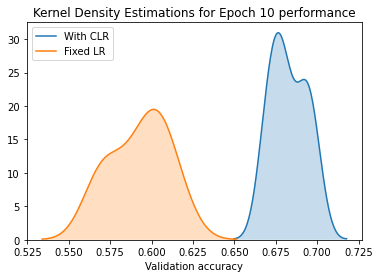

In [49]:
sns.kdeplot(new_logs['clr'][9],shade=True,label="With CLR",bw=)
sns.kdeplot(new_logs['reg'][9],shade=True,label = "Fixed LR")
plt.title("Kernel Density Estimations for Epoch 10 performance")
plt.xlabel("Validation accuracy")

#### CNN Results

##### T-test results for mean comparison between methods:

In [ ]:
sm.ttest_ind(clr_val_accs,reg_val_accs,alternative="larger")

Text(0.5, 0, 'Validation accuracy')

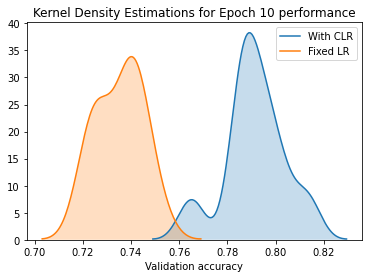

In [276]:
sns.kdeplot(clr_val_accs,shade=True,label="With CLR")
sns.kdeplot(reg_val_accs,shade=True,label = "Fixed LR")
plt.title("Kernel Density Estimations for Epoch 10 performance")
plt.xlabel("Validation accuracy")

### Running results

#### Resnet epoch-wise comparison

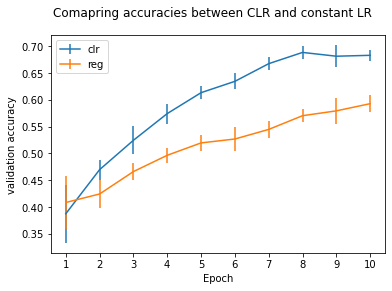

In [33]:
fig, ax = plt.subplots()
plt.suptitle('Comapring accuracies between CLR and constant LR')
for i in ['clr','reg']:
    stf = []
    sds = []
    for j in range(10):
        stf.append(np.mean(new_logs[i][j]))
        sds.append(np.std(new_logs[i][j]))
    ax.errorbar(range(1,11),stf,sds,label=i)
ax.set_xticks(range(1,11))
ax.set_xlabel("Epoch")
ax.set_ylabel("validation accuracy")
ax.legend()    

#### CNN epoch-wise comparison

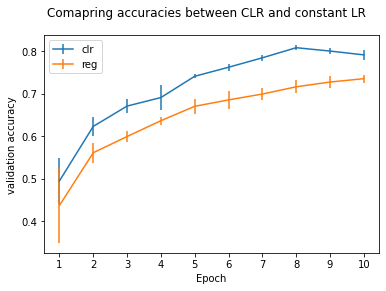

In [274]:
fig, ax = plt.subplots()
plt.suptitle('Comapring accuracies between CLR and constant LR')
for i in ['clr','reg']:
    stf = []
    sds = []
    for j in range(10):
        stf.append(np.mean(dc[i][j]))
        sds.append(np.std(dc[i][j]))
    ax.errorbar(range(1,11),stf,sds,label=i)
ax.set_xticks(range(1,11))
ax.set_xlabel("Epoch")
ax.set_ylabel("validation accuracy")
ax.legend()    

Ttest_indResult(statistic=14.151531305883196, pvalue=3.6503645258573616e-10)

In [ ]:
st.ttest_ind_from_stats()